#  Low-rank interpolative decomposition (ID)
************************************************************************************
Let $\mathbf{A}$ be a matrix of dimension $m\times n$. The approximate rank $k$ interpolative decomposition (ID) admits the following factorization 

\begin{equation}
	\begin{array}{cccccccccc}			
	\mathbf{A}  & \approx & \mathbf{C} & \mathbf{V}  \\
	m\times n &   &  m\times k & k\times n
	\end{array} 
\end{equation}

The factor matrix $\mathbf{C}$ is formed of a subset of columns of $\mathbf{A}$, also called the partial column skeleton. The factor matrix $\mathbf{V}$ contains a $k\times k$ identity matrix as a submatrix and is well-conditioned. 


### Get Started

In [55]:
import numpy as np
import scipy as sci
from scipy import ndimage 
import matplotlib.pyplot as plt

### The Dataset

First let us read in a grayscale image of dimension $1550\times 1250$ for demonstration. 

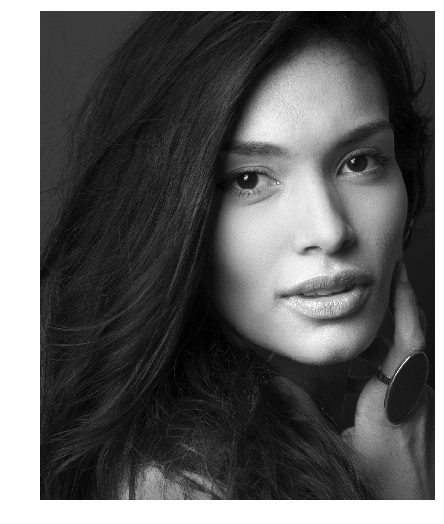

('Dimensions:', (1550, 1250))


In [56]:
# Read in image
A = sci.ndimage.imread('../data/Alejandra.jpg', flatten=True)

# Display image
fig = plt.figure(figsize=(12, 9))
plt.imshow(A, cmap = 'gray')
plt.axis('off')
plt.show()

# Print shape
m,n = A.shape
print('Dimensions:', A.shape)

###  Deterministic ID algorithm
**********************************************************************************

The deterministc ID can be computed from the colum pivoted QR decomposition
\begin{equation}
\begin{array}{cccccccccc}			
\mathbf{A} & \mathbf{P}   & \approx & \mathbf{Q} & \mathbf{R}^\top.  \\
m\times n & n\times n &  &  m\times r & r\times n
\end{array} 
\end{equation}

$\mathbf{P}$ is a permutation matrix, $\mathbf{Q}$ has orthonormal columns, and $\mathbf{R}$ is an upper triangular matrix. In SciPy, the permutation matrix $\mathbf{P}$ is efficiently be represented as a $1$-dimensional array.  

In [57]:
Q, R, P = sci.linalg.qr(A, mode='economic', pivoting=True)
print('Dimensions Q:', Q.shape)
print('Dimensions R:', R.shape)
print('Dimensions P:', P.shape)

('Dimensions Q:', (1550, 1250))
('Dimensions R:', (1250, 1250))
('Dimensions P:', (1250,))


Now assume, that we are interested in a low-rank ID approximation, with say a target-rank $k=150$, i.e, selecting $150$ columns from the input matrix (image). 

In [58]:
k=150 

Form the factor matrix $\mathbf{C}$ by selecting the first $k$ columns that were chosen as `pivots':

In [59]:
C = A[:,P[0:k]]

Let's see which are the most influential columns:

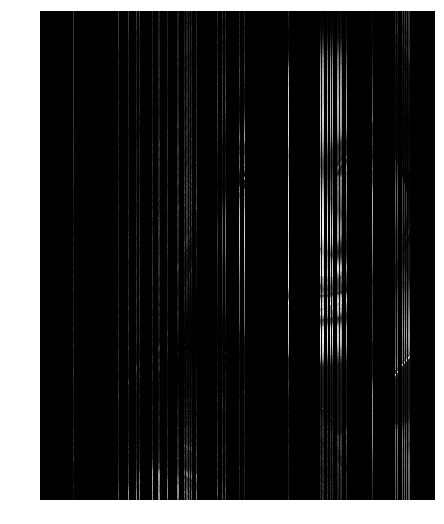

In [60]:
# Display image
partial_image = np.zeros(A.shape)
partial_image[:,P[0:k]] = C
fig = plt.figure(figsize=(12, 9))
plt.imshow(partial_image, cmap = 'gray')
plt.axis('off')
plt.show()


It remains to construct the factor matrix $\mathbf{V}$:

In [61]:
# Compute V
T =  sci.linalg.pinv2(R[0:k , 0:k]).dot(R[0:k , k:n]) 
V = sci.bmat([[np.eye(k), T]])

Now, we have the following relationship $\mathbf{A}=\mathbf{C}\left[\mathbf{I}_k \mathbf{T} \right]\mathbf{P}^\top = \mathbf{C}\mathbf{V}\mathbf{P}^\top$. Thus, we need to reorder the columns of the factor matrix $\mathbf{V}$, i.e., post-multiplying by the permutation matrix $\mathbf{P}$. We can do this efficently by using the the scipy.argsort() function, which returns the indices that would sort an array.

In [62]:
V = V[:,sci.argsort(P)]

Finally, we can compute the low-rank approximation as follows:

In [63]:
Atilde = C.dot(V)

Let's see how good the ID does:

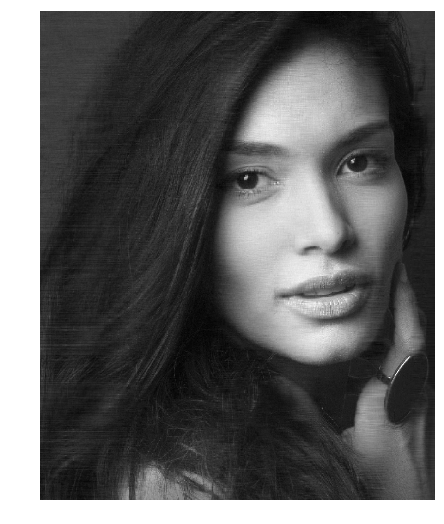

('Relative error:', 0.063968085046355649)


In [64]:
# Display image
fig = plt.figure(figsize=(12, 9))
plt.imshow(Atilde, cmap = 'gray')
plt.axis('off')
plt.show()

#Print relative error
print('Relative error:', sci.linalg.norm(A-Atilde)/sci.linalg.norm(A) )

We see, that selecting just $k=150$ columns yields a good approximation. You should try other values for $k$ as well. 

###  Randomized ID algorithm
**********************************************************************************
Computing the QR decomposition of a large dense matrix is computationally expensive. Instead, we can compute the QR decomposition on a smaller matrix
\begin{equation}
	\begin{array}{cccccccccc}			
	\mathbf{Y}  & \approx & \mathbf{\Omega} & \mathbf{A}.  \\
	k\times n &   &  k\times m & m\times n
	\end{array} 
\end{equation}

$\mathbf{\Omega}$ is a random test matrix. Once, the sketch $\mathbf{Y}$ is obtained, we can proceed as described above. In practice, we slightly oversample denoted by the parameter $p$.

First, generate the random test matrix $\mathbf{\Omega}$:

In [65]:
p = 10 # Oversampling parameter
Omega = sci.random.standard_normal(((k+p),m))

Then, compute the sketch $\mathbf{Y}$:

In [66]:
Y = Omega.dot(A)

Finally proceed by following the steps described above:

In [67]:
Q, R, P = sci.linalg.qr(Y, mode='economic', pivoting=True)
# Select column subset
C = A[:,P[0:k]]
# Compute V
T =  sci.linalg.pinv(R[0:k , 0:k]).dot(R[0:k , k:n]) 
V = sci.bmat([[np.eye(k), T]])
V = V[:,sci.argsort(P)]

Display the columns selected by the randomized algorithm:

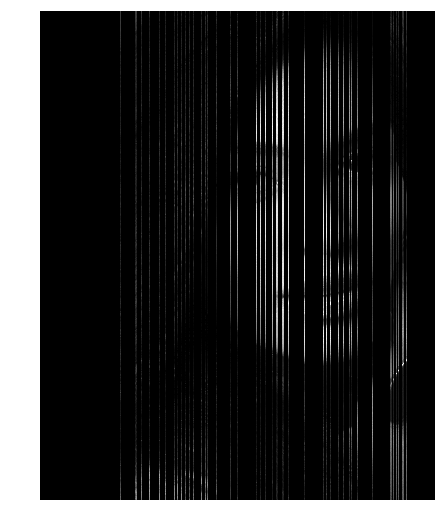

In [68]:
# Display image
partial_image = np.zeros(A.shape)
partial_image[:,P[0:k]] = C
fig = plt.figure(figsize=(12, 9))
plt.imshow(partial_image, cmap = 'gray')
plt.axis('off')
plt.show()

Let's see the performance:

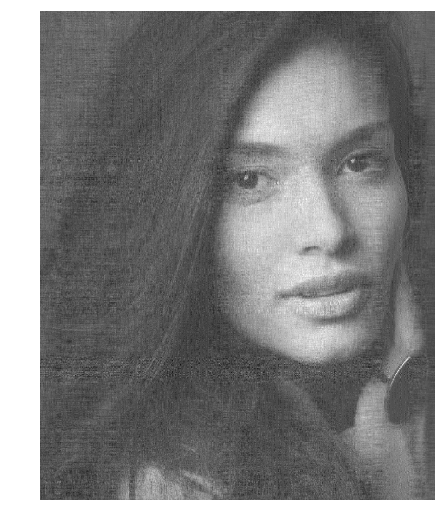

('Relative error:', 0.15864280039118675)


In [69]:
#Low-rank approximation
Atilde = C.dot(V)

# Display image
fig = plt.figure(figsize=(12, 9))
plt.imshow(Atilde, cmap = 'gray')
plt.axis('off')
plt.show()

#Print relative error
print('Relative error:', sci.linalg.norm(A-Atilde)/sci.linalg.norm(A) )

Compared to the deterministic ID the randomized algorithms performs slightly weaker in terms of the accuracy. However, the approximation quality can be improved using the power scheme and oversampling. 

###  Computing the interpolative decomposition (ID) using ristretto
**********************************************************************************
Let's wrap up things and use the ristretto library to compute the ID.

In [70]:
import ristretto.mf 

Deterministic ID:

In [71]:
%%timeit
C, V = ristretto.mf.interp_decomp(A, k=k, mode='column')

1 loop, best of 3: 306 ms per loop


In [72]:
C, V = ristretto.mf.interp_decomp(A, k=k, mode='column')
#Print relative error
Atilde = C.dot(V)
print('Relative error:', sci.linalg.norm(A-Atilde)/sci.linalg.norm(A) )

('Relative error:', 0.063968085046355649)


Randomized ID without power iterations:

In [73]:
%%timeit
C, V = ristretto.mf.rinterp_decomp(A, k=k, p=10, q=0, mode='column')

10 loops, best of 3: 32 ms per loop


In [74]:
C, V = ristretto.mf.rinterp_decomp(A, k=k, p=10, q=0, mode='column')
#Print relative error
Atilde = C.dot(V)
print('Relative error:', sci.linalg.norm(A-Atilde)/sci.linalg.norm(A) )

('Relative error:', 0.15750383908724588)


Randomized ID with $q=2$ power iterations:

In [75]:
%%timeit
C, V = ristretto.mf.rinterp_decomp(A, k=k, p=50, q=2, mode='column')

10 loops, best of 3: 79.2 ms per loop


In [76]:
C, V = ristretto.mf.rinterp_decomp(A, k=k, p=50, q=2, mode='column')
#Print relative error
Atilde = C.dot(V)
print('Relative error:', sci.linalg.norm(A-Atilde)/sci.linalg.norm(A) )

('Relative error:', 0.077110911857855249)


#  CUR decomposition
************************************************************************************
Let $\mathbf{A}$ be a matrix of dimension $m\times n$. The approximate rank $k$ interpolative decomposition (ID) admits the following factorization 

\begin{equation}
	\begin{array}{cccccccccc}			
	\mathbf{A}  & \approx & \mathbf{C} & \mathbf{U}  & \mathbf{R} \\
	m\times n &   &  m\times k & k\times k & k\times n
	\end{array} 
\end{equation}

The factor matrix $\mathbf{C}$ is formed of a subset of columns of $\mathbf{A}$, also called the partial column skeleton. The factor matrix $\mathbf{R}$ is formed of a subset of rows of $\mathbf{A}$, also called the partial row skeleton. The factor matrix $\mathbf{U}$ is designed so that the equation above is satisfied, i.e., $\mathbf{U} = \mathbf{C}^\dagger \mathbf{A} \mathbf{R}^\dagger$.

Deterministic CUR:

In [77]:
%%timeit
C, U, R = ristretto.mf.cur(A, k=k)

1 loop, best of 3: 315 ms per loop


In [78]:
C, U, R = ristretto.mf.cur(A, k=k)#Print relative error
Atilde = C.dot(U).dot(R)
print('Relative error:', sci.linalg.norm(A-Atilde)/sci.linalg.norm(A) )

('Relative error:', 0.076666622064003445)


Randomized CUR without power iterations:

In [79]:
%%timeit
C, U, R = ristretto.mf.rcur(A, k=k, p=10, q=0)

10 loops, best of 3: 51.8 ms per loop


In [80]:
C, U, R = ristretto.mf.rcur(A, k=k, p=10, q=0)#Print relative error
Atilde = C.dot(U).dot(R)
print('Relative error:', sci.linalg.norm(A-Atilde)/sci.linalg.norm(A) )

('Relative error:', 0.1224893532776182)


Randomized CUR with $q=2$ power iterations:

In [81]:
%%timeit
C, U, R = ristretto.mf.rcur(A, k=k, p=50, q=2)

10 loops, best of 3: 107 ms per loop


In [82]:
C, U, R = ristretto.mf.rcur(A, k=k, p=50, q=2)#Print relative error
Atilde = C.dot(U).dot(R)
print('Relative error:', sci.linalg.norm(A-Atilde)/sci.linalg.norm(A) )

('Relative error:', 0.081836921451446068)


Display selected row and columns:

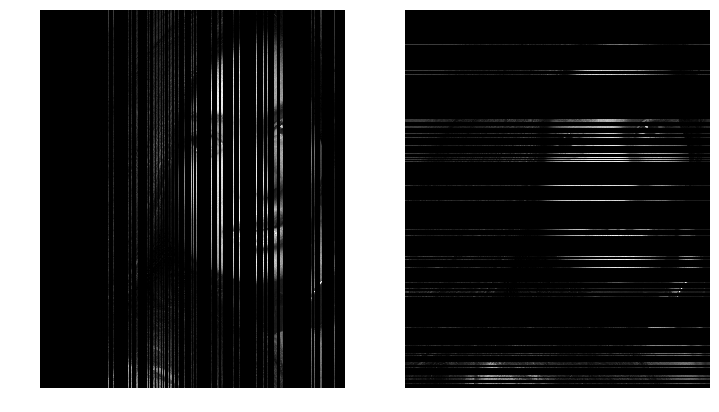

In [83]:
C, U, R = ristretto.mf.rcur(A, k=k, p=50, q=2, index_set=True)#Print relative error

# Display image
fig, ax = plt.subplots(1,2, figsize=(12, 9))

partial_image = np.zeros(A.shape)
partial_image[:,C[0:k]] = A[:,C[0:k]]
ax[0].imshow(partial_image, cmap = 'gray')
ax[0].axis('off')

partial_image = np.zeros(A.shape)
partial_image[R[0:k],] = A[R[0:k],]
ax[1].imshow(partial_image, cmap = 'gray')
ax[1].axis('off')

plt.show()

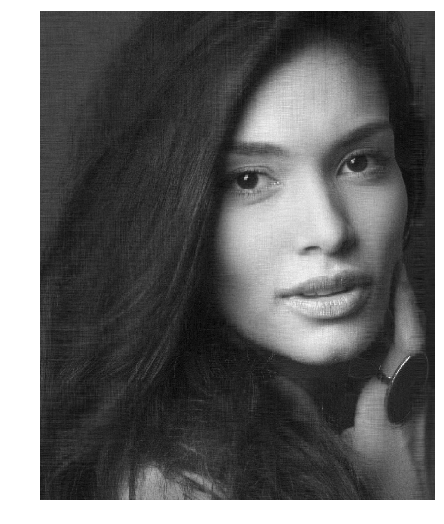

In [84]:
C, U, R = ristretto.mf.rcur(A, k=k, p=50, q=2, index_set=False)#Print relative error

#Low-rank approximation
Atilde = C.dot(U).dot(R)

# Display image
fig = plt.figure(figsize=(12, 9))
plt.imshow(Atilde, cmap = 'gray')
plt.axis('off')
plt.show()